In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from morpheus.project.application.write import project_command_bus
from morpheus.project.application.read.ModelReader import ModelReader

## Setup the Rio Primero project

In [3]:
from morpheus.project.types.User import UserId
from morpheus.project.types.Project import ProjectId, Name, Description, Tags
from morpheus.project.application.write.Project import CreateProjectCommand

user_id = UserId.new()
project_id = ProjectId.new()

create_project_command = CreateProjectCommand(
  project_id=project_id,
  name=Name('Rio Primero 123'),
  description=Description('Rio Primero Project in Argentina'),
  tags=Tags.from_list(['rio primero', 'argentina']),
  user_id=user_id
)

project_command_bus.dispatch(create_project_command)

# Create Model

In [4]:
from morpheus.project.types.discretization.spatial import Rotation
from morpheus.project.types.geometry import Polygon
from morpheus.project.types.Model import ModelId
from morpheus.project.application.write.Model import CreateModelCommand

model_id = ModelId.new()

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.922514437551428, 50.964720483303836),
    (13.925250781947113, 50.965228748412386),
    (13.925036413951403, 50.96623732041704),
    (13.92222441026388, 50.96629040370362),
    (13.922514437551428, 50.964720483303836)
  ]]
)

create_model_command = CreateModelCommand(
  project_id=project_id,
  user_id=user_id,
  model_id=model_id,
  geometry=polygon,
  n_cols=100,
  n_rows=50,
  rotation=Rotation.from_float(0.0),
)

project_command_bus.dispatch(create_model_command)

## Setup Time Discretization

In [5]:
from datetime import datetime
from morpheus.project.application.write.Model import UpdateModelTimeDiscretizationCommand
from morpheus.project.types.discretization.time import TimeDiscretization
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2015, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

update_model_time_discretization_command = UpdateModelTimeDiscretizationCommand(
  project_id=project_id,
  time_discretization=time_discretization,
  user_id=user_id,
)

project_command_bus.dispatch(update_model_time_discretization_command)

## Create Top Layer

In [6]:
from morpheus.project.types.layers.Layer import LayerId, LayerName, LayerProperties, LayerDescription, LayerConfinement
from morpheus.project.application.write.Model import CreateModelLayerCommand

create_model_layer_command = CreateModelLayerCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=LayerId.new(),
  name=LayerName('Top Layer'),
  confinement=LayerConfinement.convertible(),
  description=LayerDescription('Top Layer'),
  properties=LayerProperties.from_values(
    top=460,
    bottom=450,
    initial_head=460,
    hk=8.64,
    hani=1,
    vka=0.864,
    specific_storage=1e-5,
    specific_yield=0.2
  )
)

project_command_bus.dispatch(create_model_layer_command)

In [7]:
model_reader = ModelReader()
model = model_reader.get_latest_model(project_id)
model.layers

LayersCollection(layers=[Layer(layer_id=LayerId(value='72cfd0d7-79f5-41f3-bf1d-b4695f8c366e'), name=LayerName(value='Default'), description=LayerDescription(value='Default'), confinement=LayerConfinement(type='confined'), properties=LayerProperties(hk=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1.0), raster=None, zones=None), hani=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1.0), raster=None, zones=None), vka=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1.0), raster=None, zones=None), specific_storage=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.0001), raster=None, zones=None), specific_yield=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.1), raster=None, zones=None), initial_head=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1.0), raster=None, zones=None), top=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1.0), raster=None, zones=None), bottom=LayerPropertyValues(value=LayerPropertyDefaultValu

# Create Aquitard Layer

In [8]:
create_model_layer_command = CreateModelLayerCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=LayerId.new(),
  name=LayerName('Aquitard'),
  confinement=LayerConfinement.confined(),
  description=LayerDescription('Aquitard'),
  properties=LayerProperties.from_values(
    top=450.0,
    bottom=448.0,
    initial_head=450.0,
    hk=10,
    hani=1,
    vka=0.1,
    specific_storage=1e-5,
    specific_yield=0.2,
  )
)

project_command_bus.dispatch(create_model_layer_command)

# Create Aquifer Layer

In [9]:
create_model_layer_command = CreateModelLayerCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=LayerId.new(),
  name=LayerName('Aquifer'),
  confinement=LayerConfinement.confined(),
  description=LayerDescription('Aquifer'),
  properties=LayerProperties.from_values(
    top=448,
    bottom=390,
    initial_head=448,
    hk=8.64,
    hani=1,
    vka=0.864,
    specific_storage=1e-5,
    specific_yield=0.2,
  )
)

project_command_bus.dispatch(create_model_layer_command)

# Remove default layer

In [10]:
# get latest project layers

model_reader = ModelReader()
model = model_reader.get_latest_model(project_id)

layers = model.layers

# default layer id
default_layer_id = layers[0].layer_id

# remove default layer
from morpheus.project.application.write.Model import DeleteModelLayerCommand

delete_model_layer_command = DeleteModelLayerCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=default_layer_id
)

project_command_bus.dispatch(delete_model_layer_command)

## Update Model Layer Name and Description and Type

In [11]:
from morpheus.project.application.write.Model import UpdateModelLayerMetadataCommand

model_reader = ModelReader()
model = model_reader.get_latest_model(project_id)

layers = model.layers

# bottom layer id
bottom_layer_id = layers[-1].layer_id

update_model_layer_command = UpdateModelLayerMetadataCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=bottom_layer_id,
  layer_name=LayerName('Bottom Layer'),
  layer_description=LayerDescription('Bottom Layer'),
)

project_command_bus.dispatch(update_model_layer_command)

model = model_reader.get_latest_model(project_id)
model.layers[-1]

Layer(layer_id=LayerId(value='575ca597-6947-4d26-b478-9eeab93c6d9c'), name=LayerName(value='Bottom Layer'), description=LayerDescription(value='Bottom Layer'), confinement=LayerConfinement(type='confined'), properties=LayerProperties(hk=LayerPropertyValues(value=LayerPropertyDefaultValue(value=8.64), raster=None, zones=None), hani=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1), raster=None, zones=None), vka=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.864), raster=None, zones=None), specific_storage=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1e-05), raster=None, zones=None), specific_yield=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.2), raster=None, zones=None), initial_head=LayerPropertyValues(value=LayerPropertyDefaultValue(value=448), raster=None, zones=None), top=LayerPropertyValues(value=LayerPropertyDefaultValue(value=448), raster=None, zones=None), bottom=LayerPropertyValues(value=LayerPropertyDefaultValue(value=390), r

## Update Model Layer Properties

In [12]:
from morpheus.project.application.write.Model import UpdateModelLayerPropertyDefaultValueCommand
from morpheus.project.types.layers.Layer import LayerPropertyName, LayerPropertyDefaultValue

model_reader = ModelReader()
model = model_reader.get_latest_model(project_id)

layers = model.layers

# bottom layer id
bottom_layer_id = layers[-1].layer_id

update_model_layer_property_command = UpdateModelLayerPropertyDefaultValueCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=bottom_layer_id,
  property_name=LayerPropertyName.from_value('hk'),
  property_default_value=LayerPropertyDefaultValue.from_value(8.64),
)

project_command_bus.dispatch(update_model_layer_property_command)

model = model_reader.get_latest_model(project_id)
model.layers[-1].properties.hk

LayerPropertyValues(value=LayerPropertyDefaultValue(value=8.64), raster=None, zones=None)

## Update Model Layer Property with Zones

In [13]:
from morpheus.project.application.write.Model.UpdateModelLayerPropertyZones import LayerPropertyZoneWithOptionalAffectedCells, UpdateModelLayerPropertyZonesCommand
from morpheus.project.types.geometry.MultiPolygon import MultiPolygon

bottom_left_top_right_polygons = MultiPolygon(
  type='MultiPolygon',
  coordinates=[
    [[
      (13.92223, 50.9647),
      (13.92223, 50.9650),
      (13.92400, 50.9650),
      (13.92400, 50.9647),
      (13.92223, 50.9647)
    ]],
    [[
      (13.924, 50.965),
      (13.924, 50.966),
      (13.925, 50.966),
      (13.925, 50.965),
      (13.924, 50.965)
    ]]
  ]
)

bottom_right_polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.923, 50.965),
    (13.923, 50.966),
    (13.924, 50.966),
    (13.924, 50.965),
    (13.923, 50.965)
  ]]
)

zones = [
  LayerPropertyZoneWithOptionalAffectedCells.from_payload({
    'name': 'Zone 1',
    'geometry': bottom_left_top_right_polygons.to_dict(),
    'value': 5
  }),
  LayerPropertyZoneWithOptionalAffectedCells.from_payload({
    'name': 'Zone 2',
    'geometry': bottom_right_polygon.to_dict(),
    'value': 10
  })
]

update_model_layer_property_command = UpdateModelLayerPropertyZonesCommand(
  project_id=project_id,
  model_id=model_id,
  user_id=user_id,
  layer_id=bottom_layer_id,
  property_name=LayerPropertyName.from_value('hk'),
  property_zones=zones,
)

project_command_bus.dispatch(update_model_layer_property_command)

model = model_reader.get_latest_model(project_id)
model.layers[-1].properties.hk.get_data()

[[8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64],
 [8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,
  8.64,

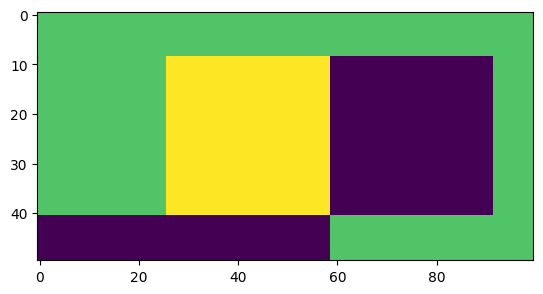

In [14]:
model.layers[-1].properties.hk.get_data()

import matplotlib.pyplot as plt

plt.imshow(model.layers[-1].properties.hk.get_data())

# Show model version

In [15]:
model_reader = ModelReader()
model_reader.get_versions(project_id=project_id)


[ModelVersion(version_id=VersionId(value='ae4ced1c-60ec-4794-9c0f-039fa8ec966d'), tag=VersionTag(value='v0.0.0'), description=VersionDescription(value='Initial version'))]

In [16]:
model_reader = ModelReader()
model = model_reader.get_latest_model(project_id)
model.layers

LayersCollection(layers=[Layer(layer_id=LayerId(value='795c7660-c344-40c9-8025-59e314ce99d6'), name=LayerName(value='Top Layer'), description=LayerDescription(value='Top Layer'), confinement=LayerConfinement(type='convertible'), properties=LayerProperties(hk=LayerPropertyValues(value=LayerPropertyDefaultValue(value=8.64), raster=None, zones=None), hani=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1), raster=None, zones=None), vka=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.864), raster=None, zones=None), specific_storage=LayerPropertyValues(value=LayerPropertyDefaultValue(value=1e-05), raster=None, zones=None), specific_yield=LayerPropertyValues(value=LayerPropertyDefaultValue(value=0.2), raster=None, zones=None), initial_head=LayerPropertyValues(value=LayerPropertyDefaultValue(value=460), raster=None, zones=None), top=LayerPropertyValues(value=LayerPropertyDefaultValue(value=460), raster=None, zones=None), bottom=LayerPropertyValues(value=LayerPropertyDefa